# Housing Pricing Linear Regression Analysis

This notebook explores the housing dataset. The dataset contains 21 variables describing various aspects of residential homes in washington. The goal is to predict the Sale Price of the houses.

VIF method used to calculate the multicolinearity between features.It's helped me to remove Sqft_living feature, which is highly correlated to the other features(observed correlation is 1.0)

To improve my model, Zipcode datatype converted into Categorical and before train the model converted to numerical using dummyfying method.

The performances of various regression techniques such as Linear Regression, KNeighbors Regressor, LassoRegression and Random forest regressor are compared. Using the best fit model(LinearRegression), I got the r2 score = 0.88, RMSE = 0.17 in the House price prediction.

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


In [2]:
pd.__version__ #To import the excel file

'1.4.2'

### Read data file

In [3]:
data = pd.read_excel('/Users/vihaan/Desktop/data_mid_bootcamp_project_regression/regression_data.xls')

In [4]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


In [5]:
data.shape

(21597, 21)

In [6]:
duplicates = data[data.duplicated(subset=['id'])]
print(len(duplicates))

177


We note that there are multiple entries with same id. This would be due to the fact that a house may have been sold twice and thus have two entries.

For now we will keep entries and allow the model to treat them as seperate data points.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  int64         
 8   view           21597 non-null  int64         
 9   condition      21597 non-null  int64         
 10  grade          21597 non-null  int64         
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  int64         
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   21597 non-null  int64         
 15  zipcode        2159

There are no missing(Null), duplicate values and categorical featues to deal with.

<AxesSubplot:title={'center':'Heatmap of missing values'}>

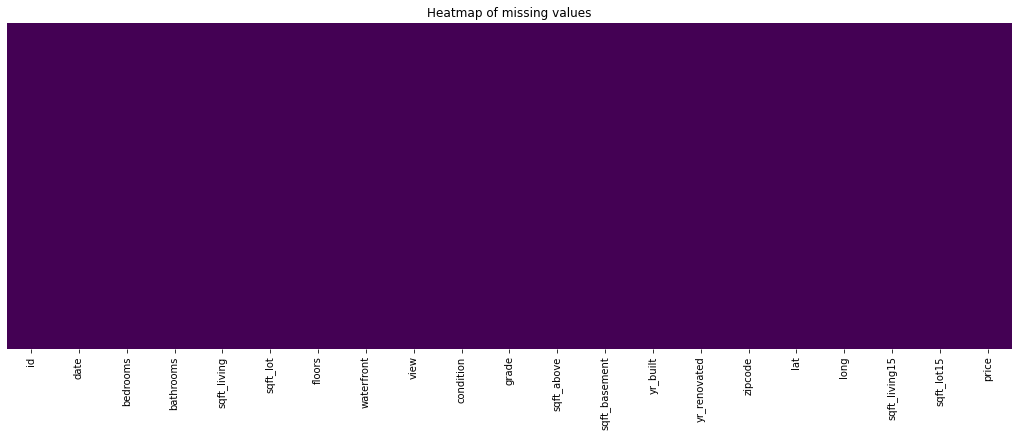

In [8]:
#Checking Null or missing values by using heatmap
plt.figure(figsize=(18,6))
plt.title('Heatmap of missing values')
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Data Cleaning

In [9]:
data = data.set_index('id') # set the DataFrame index as 'id'
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
id,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


In [10]:
#Converting month and year from  'Date' feature to compare the data in better way
data['year']= pd.DatetimeIndex(data['date']).year 
data['month']= pd.DatetimeIndex(data['date']).month

In [11]:
#collation month and year from Date, so decided to drop the feature
data = data.drop(['date'], axis=1)
data.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,year,month
id,,,,,,,,,,,,,,,,,,,,,
7129300520,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,1955,0,98178,47.5112,-122.257,1340,5650,221900,2014,10
6414100192,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,1951,1991,98125,47.7210,-122.319,1690,7639,538000,2014,12
5631500400,2,1.00,770,10000,1.0,0,0,3,6,770,...,1933,0,98028,47.7379,-122.233,2720,8062,180000,2015,2
2487200875,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,1965,0,98136,47.5208,-122.393,1360,5000,604000,2014,12
1954400510,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,1987,0,98074,47.6168,-122.045,1800,7503,510000,2015,2


In [12]:
# Converting the zipcode to a string, To check the relation between other features
# To check, my model performs better or not
data['zipcode'] = data['zipcode'].astype(str)

In [13]:
data.corr().apply(lambda x: round(x,4))

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,price,year,month
bedrooms,1.0000,0.5145,0.5782,0.0325,0.1779,-0.0068,0.0800,0.0265,0.3566,0.4794,0.3028,0.1557,0.0184,-0.0100,0.1321,0.3934,0.0307,0.3088,-0.0099,-0.0010
bathrooms,0.5145,1.0000,0.7558,0.0884,0.5026,0.0637,0.1884,-0.1265,0.6658,0.6867,0.2834,0.5072,0.0505,0.0243,0.2249,0.5699,0.0883,0.5259,-0.0266,0.0075
sqft_living,0.5782,0.7558,1.0000,0.1735,0.3540,0.1039,0.2847,-0.0594,0.7628,0.8764,0.4351,0.3182,0.0553,0.0522,0.2412,0.7564,0.1843,0.7019,-0.0290,0.0121
sqft_lot,0.0325,0.0884,0.1735,1.0000,-0.0048,0.0216,0.0749,-0.0088,0.1147,0.1841,0.0154,0.0529,0.0077,-0.0855,0.2302,0.1448,0.7182,0.0899,0.0056,-0.0026
floors,0.1779,0.5026,0.3540,-0.0048,1.0000,0.0238,0.0288,-0.2641,0.4588,0.5240,-0.2457,0.4892,0.0064,0.0492,0.1259,0.2801,-0.0107,0.2568,-0.0224,0.0142
waterfront,-0.0068,0.0637,0.1039,0.0216,0.0238,1.0000,0.4020,0.0166,0.0829,0.0721,0.0806,-0.0262,0.0929,-0.0143,-0.0419,0.0865,0.0308,0.2664,-0.0042,0.0081
view,0.0800,0.1884,0.2847,0.0749,0.0288,0.4020,1.0000,0.0460,0.2517,0.1676,0.2771,-0.0536,0.1040,0.0059,-0.0781,0.2807,0.0729,0.3974,0.0013,-0.0054
condition,0.0265,-0.1265,-0.0594,-0.0088,-0.2641,0.0166,0.0460,1.0000,-0.1469,-0.1589,0.1738,-0.3616,-0.0608,-0.0151,-0.1059,-0.0931,-0.0031,0.0361,-0.0459,0.0224
grade,0.3566,0.6658,0.7628,0.1147,0.4588,0.0829,0.2517,-0.1469,1.0000,0.7561,0.1682,0.4479,0.0143,0.1136,0.2003,0.7139,0.1210,0.6680,-0.0306,0.0090
sqft_above,0.4794,0.6867,0.8764,0.1841,0.5240,0.0721,0.1676,-0.1589,0.7561,1.0000,-0.0522,0.4240,0.0233,-0.0012,0.3448,0.7318,0.1951,0.6054,-0.0238,0.0102


## EDA

In [14]:
data.describe().apply(lambda x: round(x,2))

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,price,year,month
count,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00
mean,3.37,2.12,2080.32,15099.41,1.49,0.01,0.23,3.41,7.66,1788.60,291.73,1971.00,84.46,47.56,-122.21,1986.62,12758.28,540296.57,2014.32,6.57
std,0.93,0.77,918.11,41412.64,0.54,0.09,0.77,0.65,1.17,827.76,442.67,29.38,401.82,0.14,0.14,685.23,27274.44,367368.14,0.47,3.12
min,1.00,0.50,370.00,520.00,1.00,0.00,0.00,1.00,3.00,370.00,0.00,1900.00,0.00,47.16,-122.52,399.00,651.00,78000.00,2014.00,1.00
25%,3.00,1.75,1430.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,0.00,1951.00,0.00,47.47,-122.33,1490.00,5100.00,322000.00,2014.00,4.00
50%,3.00,2.25,1910.00,7618.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,47.57,-122.23,1840.00,7620.00,450000.00,2014.00,6.00
75%,4.00,2.50,2550.00,10685.00,2.00,0.00,0.00,4.00,8.00,2210.00,560.00,1997.00,0.00,47.68,-122.12,2360.00,10083.00,645000.00,2015.00,9.00
max,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,47.78,-121.32,6210.00,871200.00,7700000.00,2015.00,12.00


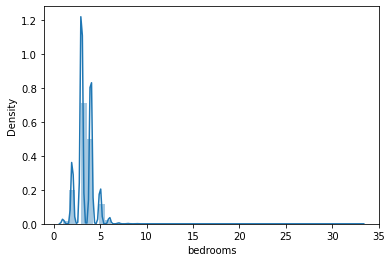

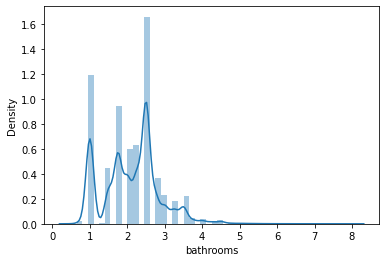

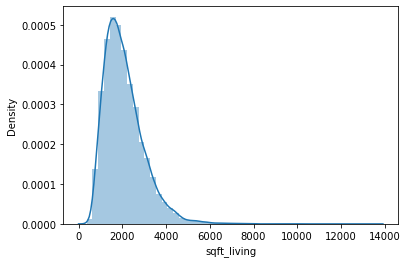

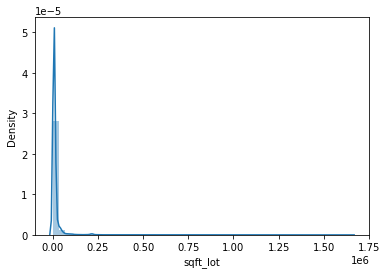

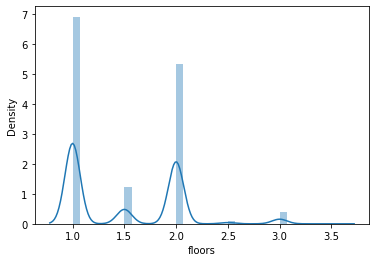

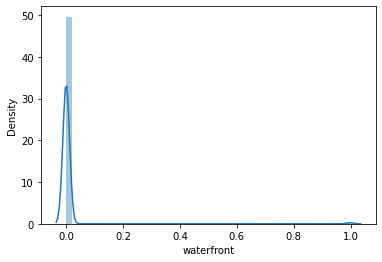

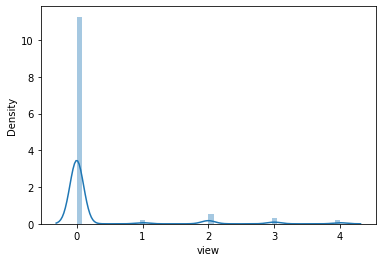

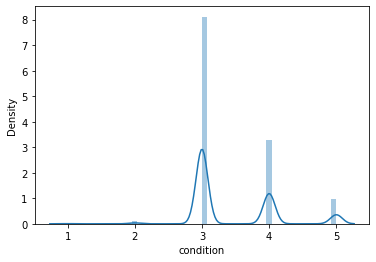

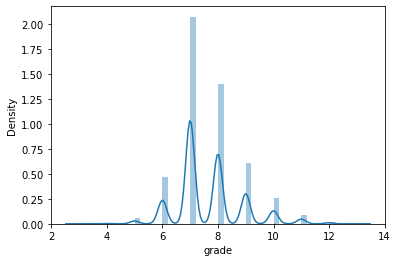

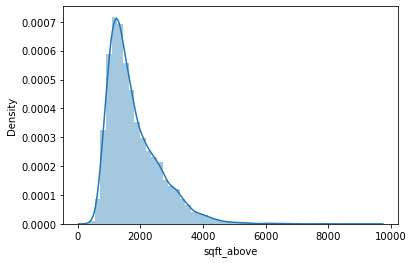

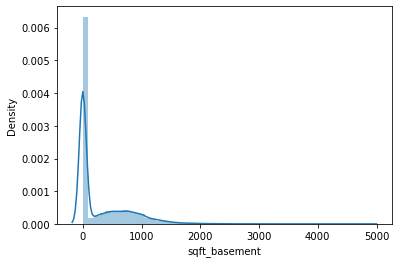

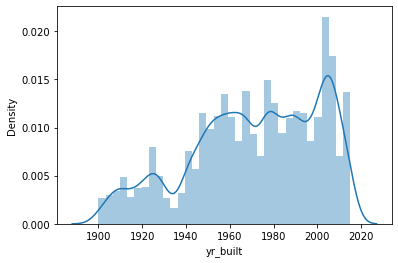

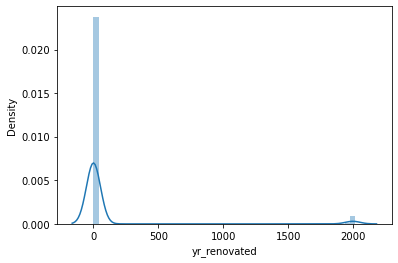

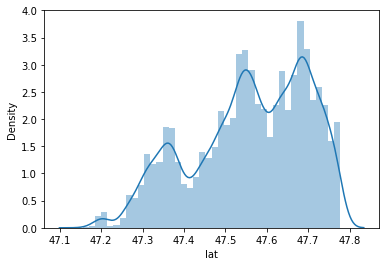

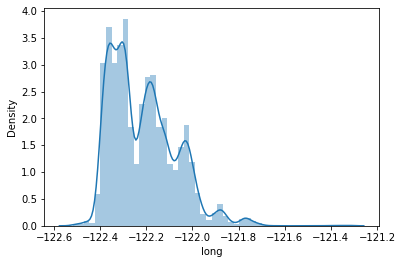

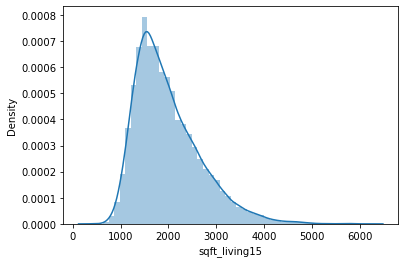

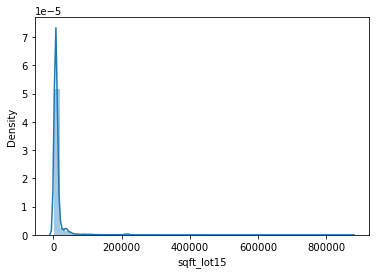

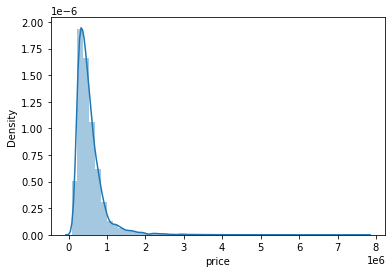

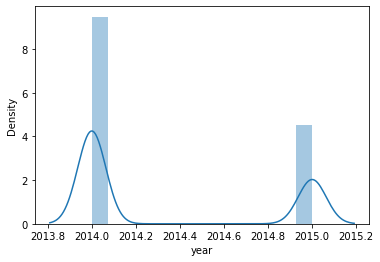

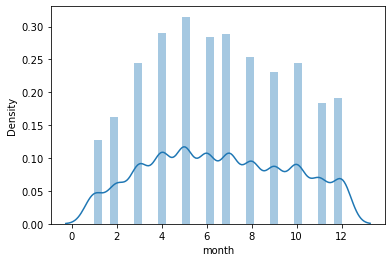

In [15]:
#sqft_living, sqft_above, sqft_living15: These feature are distributed Normally
#To check the skewing and how the data disributed
for column in data.select_dtypes(np.number).columns:
    sns.distplot(data[column])
    plt.show()

### Checking outliers

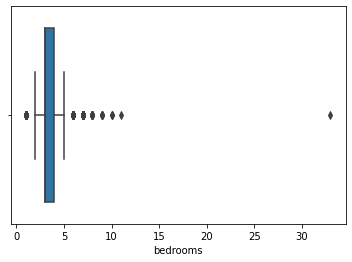

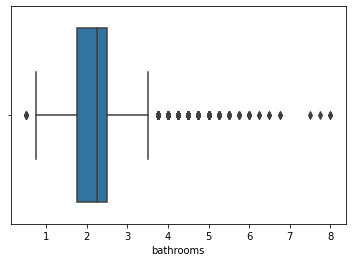

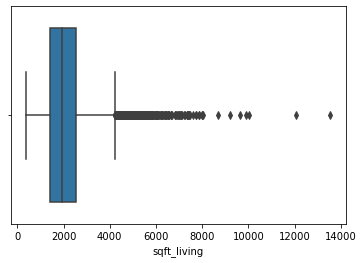

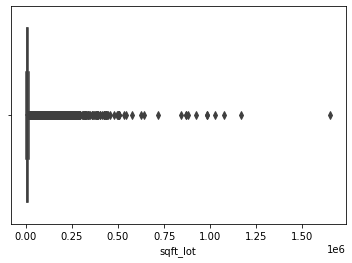

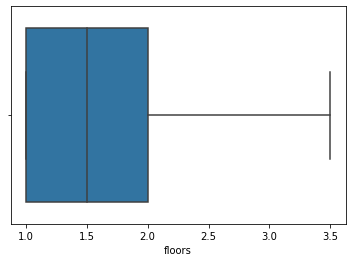

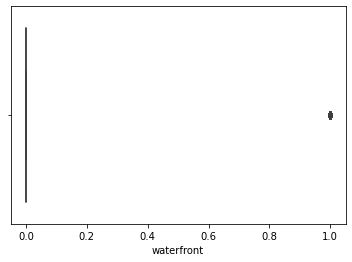

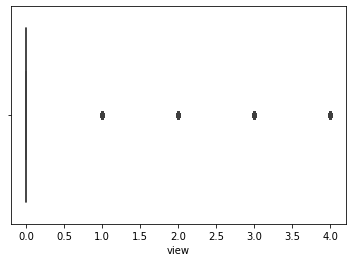

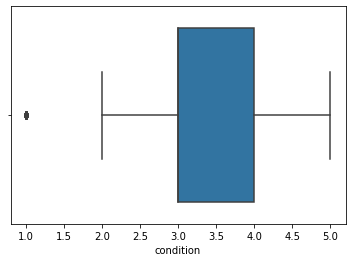

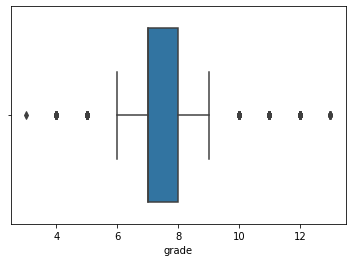

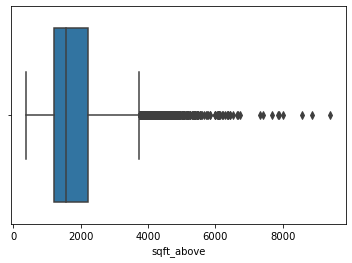

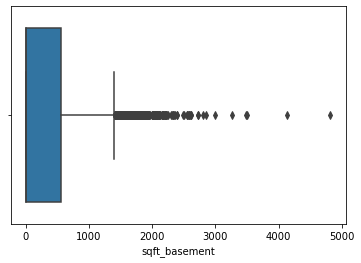

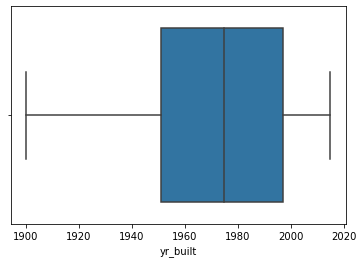

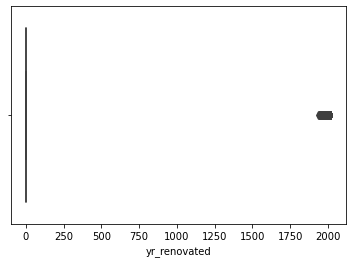

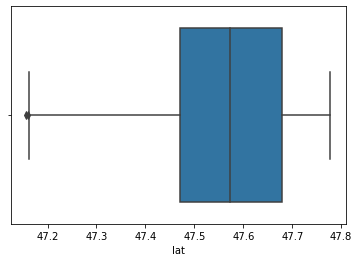

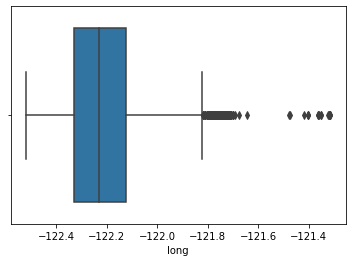

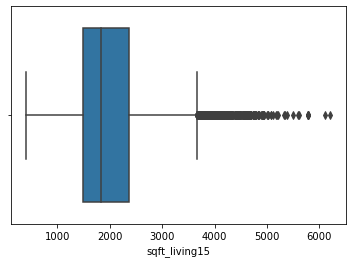

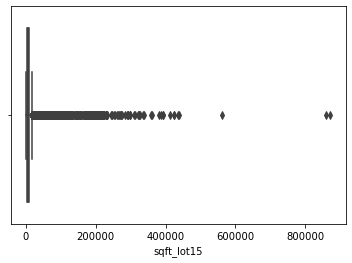

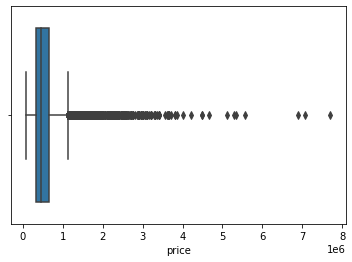

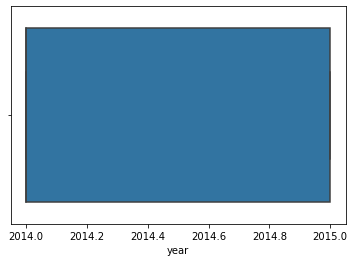

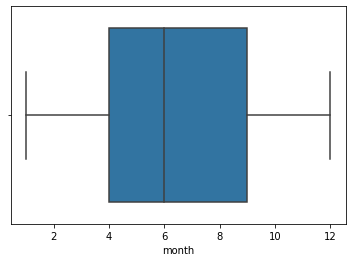

In [16]:
for column in data.select_dtypes(np.number).columns:
    sns.boxplot(data[column])
    plt.show()

In [17]:
data[data['price'] < 5000000]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,year,month
id,,,,,,,,,,,,,,,,,,,,,
7129300520,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,1955,0,98178,47.5112,-122.257,1340,5650,221900,2014,10
6414100192,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,1951,1991,98125,47.7210,-122.319,1690,7639,538000,2014,12
5631500400,2,1.00,770,10000,1.0,0,0,3,6,770,...,1933,0,98028,47.7379,-122.233,2720,8062,180000,2015,2
2487200875,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,1965,0,98136,47.5208,-122.393,1360,5000,604000,2014,12
1954400510,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,1987,0,98074,47.6168,-122.045,1800,7503,510000,2015,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,3,2.50,1530,1131,3.0,0,0,3,8,1530,...,2009,0,98103,47.6993,-122.346,1530,1509,360000,2014,5
6600060120,4,2.50,2310,5813,2.0,0,0,3,8,2310,...,2014,0,98146,47.5107,-122.362,1830,7200,400000,2015,2
1523300141,2,0.75,1020,1350,2.0,0,0,3,7,1020,...,2009,0,98144,47.5944,-122.299,1020,2007,402101,2014,6


At first checking outliers on the Target(price) variable:

I won't drop anything just yet. If i drop Target Feature outliers, I will loose some data, which may important to my model.

In other features also having Outliers, but I'd leave that for now, later i will use one of scaling(Standard Scaler) method. Outliers may important for the better model.

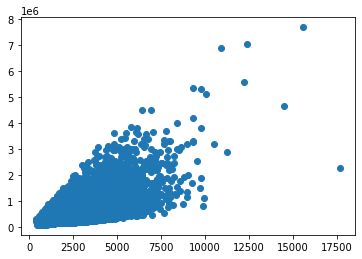

In [18]:
plt.scatter((data['sqft_living']+data['sqft_basement']),data['price'])

Text(0.5, 1.0, 'Waterfront vs Price ( 0= no waterfront)')

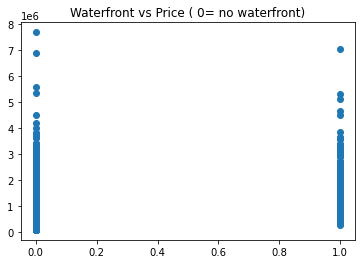

In [19]:
plt.scatter(data.waterfront,data.price)
plt.title("Waterfront vs Price ( 0= no waterfront)")

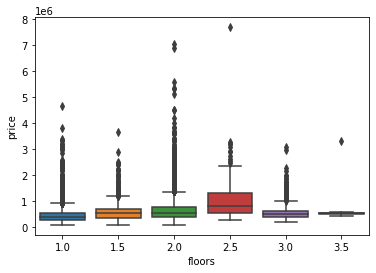

In [20]:
sns.boxplot(x='floors', y='price', data=data)
plt.show()

In [21]:
mask= np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)]=True

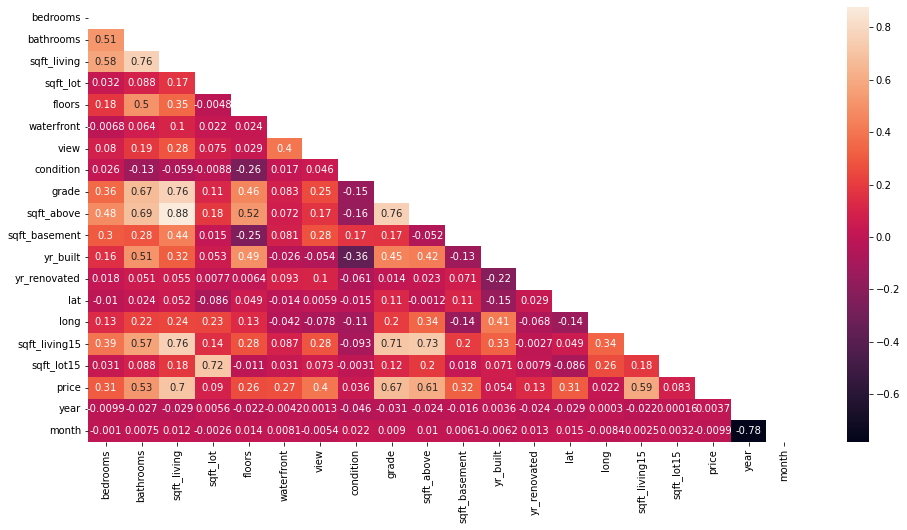

In [22]:
fig, ax = plt.subplots(figsize=(16, 8))
ax = sns.heatmap(data.corr(), mask=mask, annot=True)
plt.show()

In [23]:
#first scaling the Target using log method
#applying log transformation since it will make the 'outliers' interval smaller
def log_transform(x):
    if np.isfinite(x) and x!=0:
        return np.log(x)
    else:
        return np.NAN

In [24]:
data = data.copy()
data['price'] = data['price'].apply(log_transform)

<AxesSubplot:xlabel='price', ylabel='Density'>

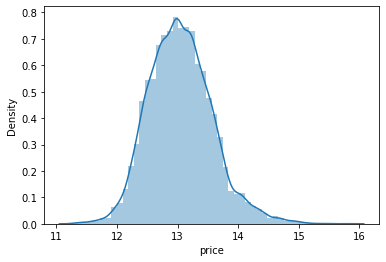

In [25]:
sns.distplot(data['price'])
# Data is normally distributed, 

In [26]:
data.corr()['price'].sort_values() 
#Correlation between features increased after scaling the Target(price)

month           -0.013064
year             0.004972
condition        0.038918
long             0.050862
yr_built         0.080583
sqft_lot15       0.092281
sqft_lot         0.100025
yr_renovated     0.114485
waterfront       0.174697
floors           0.310630
sqft_basement    0.316920
bedrooms         0.343360
view             0.346635
lat              0.448837
bathrooms        0.551249
sqft_above       0.601579
sqft_living15    0.619326
sqft_living      0.695185
grade            0.703720
price            1.000000
Name: price, dtype: float64

#### Removing outliers

In [27]:
data = data[data['sqft_lot15'] < 700000]

In [28]:
data = data[data['view'] < 3.5]

### Train Test split 

In [29]:
from sklearn.model_selection import train_test_split

X = data.drop('price', axis=1)
y = data['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train_num = X_train.select_dtypes(np.number)
X_test_num = X_test.select_dtypes(np.number)

In [30]:
#### Import StandardScaler to scale the data 
from sklearn.preprocessing import StandardScaler
import pickle

transformer = StandardScaler()
transformer.fit(X_train_num)

# saving in a pickle
with open('std_transformer.pickle', 'wb') as file:
    pickle.dump(transformer, file)
    
# loading from a pickle  
with open('std_transformer.pickle', 'rb') as file:
    loaded_transformer = pickle.load(file)

X_train_ = loaded_transformer.transform(X_train_num)
X_test_ = loaded_transformer.transform(X_test_num)

unscaled_X_train = loaded_transformer.inverse_transform(X_train_)

unscaled_X_train[0][0]

4.0

### Feature Selection - Correlations and Multi-Colinearity using VIF

Using VIF method, dropping the feature 'sqft_living' beacause it is highly correlated with other features.

My Observation: I tried to train my model using 'sqft_living' as my target and observed the r2 score is 1.0 using Linear Regression Model

In [31]:
data1 = data.copy()
numericals = data1.select_dtypes(np.number).drop(columns=['price'], axis=1)

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# vif uses OLS to calculate the factor, so we don't have the intercept
# that's why we need to assign it:
vif_numericals = add_constant(numericals)
vif_numericals

,const,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,year,month
id,,,,,,,,,,,,,,,,,,,,
7129300520,1.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650,2014,10
6414100192,1.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639,2014,12
5631500400,1.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062,2015,2
2487200875,1.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000,2014,12
1954400510,1.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503,2015,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,1.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,47.6993,-122.346,1530,1509,2014,5
6600060120,1.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,47.5107,-122.362,1830,7200,2015,2
1523300141,1.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,47.5944,-122.299,1020,2007,2014,6


In [33]:
# To remove multicolinearity automatically:

threshold = 10

while True:
    # calculates the vif
    values = [variance_inflation_factor(np.array(vif_numericals), i)
              for i in range(len(vif_numericals.columns))][1:]
    display(pd.DataFrame(values, index=vif_numericals.columns[1:]).sort_values(0))
    # checks if the highest vif is bigger than the threshold
    if max(values) > threshold:
        # finds the column that has the maximum vif
        col_index = values.index(max(values)) + 1
        column_name = vif_numericals.columns[col_index]
        # drops that column
        vif_numericals = vif_numericals.drop(column_name, axis=1)
    else:
        break

vif_numericals

,0
waterfront,1.026218
lat,1.126356
yr_renovated,1.139921
view,1.183360
condition,1.239190
long,1.506889
bedrooms,1.655452
floors,2.005961
sqft_lot,2.015953
sqft_lot15,2.060332


,0
waterfront,1.026218
lat,1.126356
yr_renovated,1.139921
view,1.183360
condition,1.239190
long,1.506889
bedrooms,1.655452
sqft_basement,2.002201
floors,2.005961
sqft_lot,2.015953


,const,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,year,month
id,,,,,,,,,,,,,,,,,,,
7129300520,1.0,3,1.00,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650,2014,10
6414100192,1.0,3,2.25,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639,2014,12
5631500400,1.0,2,1.00,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062,2015,2
2487200875,1.0,4,3.00,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000,2014,12
1954400510,1.0,3,2.00,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503,2015,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,1.0,3,2.50,1131,3.0,0,0,3,8,1530,0,2009,0,47.6993,-122.346,1530,1509,2014,5
6600060120,1.0,4,2.50,5813,2.0,0,0,3,8,2310,0,2014,0,47.5107,-122.362,1830,7200,2015,2
1523300141,1.0,2,0.75,1350,2.0,0,0,3,7,1020,0,2009,0,47.5944,-122.299,1020,2007,2014,6


In [34]:
#Dummifying the categorical data
data = pd.get_dummies(data)

#### Model selection and prediction

In [35]:
from sklearn.model_selection import train_test_split

X = data.drop('price', axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [36]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [37]:
lr.score(X_test, y_test)

0.8800608110788712

In [38]:
coeff_data = pd.DataFrame(lr.coef_,X.columns, columns=['Coefficient'])

In [39]:
coeff_data

,Coefficient
bedrooms,3.770464e-03
bathrooms,3.955416e-02
sqft_living,-1.601637e+06
sqft_lot,6.636598e-07
floors,-2.962173e-02
...,...
zipcode_98177,-6.343145e+00
zipcode_98178,-6.619755e+00
zipcode_98188,-6.643886e+00
zipcode_98198,-6.667867e+00


In [40]:
predictions = lr.predict(X_test)

In [41]:
r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), mean_squared_error(y_test, predictions, squared=False)

(0.8800608110788712, 0.12991586681825487, 0.17661553821623596)

MAE: 0.12991586681825487
MSE: 0.03119304833941071
RMSE: 0.17661553821623596


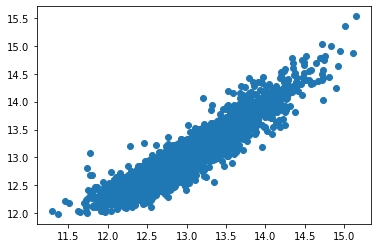

In [42]:
import matplotlib.pyplot as plt
predictions = lr.predict(X_test)  
plt.scatter(y_test,predictions)


from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions)) 
print('MSE:', metrics.mean_squared_error(y_test, predictions)) 
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions))) 

In [43]:
X = data.drop(['price'], axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Model comparision:

Tried multiple linear regression models for the best fitting model. The best ones are RandomForestRegressor and LinearRegression

In [44]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [45]:
models = []

models.append(("LinearRegression",LinearRegression()))
models.append(("KNeighbors",KNeighborsRegressor()))
models.append(("LassoRegression",Lasso()))
models.append(("RandomForestRegressor", RandomForestRegressor()))

results = []
names = []
for name,model in models:
    result = cross_val_score(model, X_test, y_test,  cv=3)
    names.append(name)
    results.append(result)

In [46]:
for i in range(len(names)):
    print(names[i],results[i])

LinearRegression [0.87968896 0.87698179 0.87223411]
KNeighbors [0.45733664 0.4679143  0.44870674]
LassoRegression [0.51024901 0.51625523 0.51728651]
RandomForestRegressor [0.87528159 0.8779873  0.87420662]


In [47]:
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score

def plot_prediction_analysis(y, y_pred, figsize=(10,4), title=''):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs[0].scatter(y, y_pred)
    mn = min(np.min(y), np.min(y_pred))
    mx = max(np.max(y), np.max(y_pred))
    axs[0].plot([mn, mx], [mn, mx], c='red')
    axs[0].set_xlabel('$y$')
    axs[0].set_ylabel('$\hat{y}$')
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    evs = explained_variance_score(y, y_pred)
    r2 = r2_score(y, y_pred)
    axs[0].set_title('rmse = {:.2f}, evs ={:.2f}, r2 = {:,.2f}'.format(rmse, evs, r2))
    
    axs[1].hist(y-y_pred, bins=50)
    avg = np.mean(y-y_pred)
    std = np.std(y-y_pred)
    axs[1].set_xlabel('$y - \hat{y}$')
    axs[1].set_title('Histogram prediction error, $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(avg, std))
                     
    if title!='':
        fig.suptitle(title)

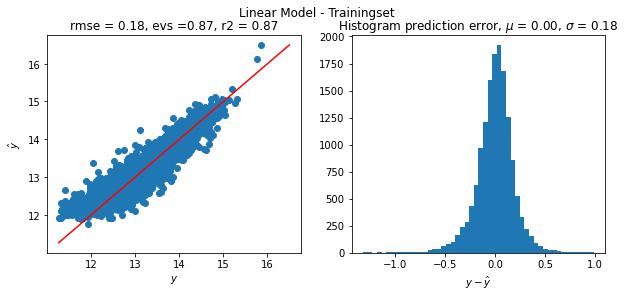

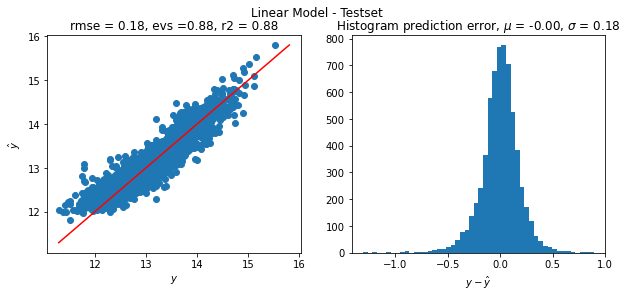

In [48]:
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
plot_prediction_analysis(y_train, y_train_pred, title = 'Linear Model - Trainingset')

y_test_pred = lr.predict(X_test)
plot_prediction_analysis(y_test, y_test_pred, title = 'Linear Model - Testset')

My Observations:

Before converting Zipcode into Categorical, the LinearRegression model r2 score is: 0.76.

After converting Zipcode into Categorical, the LinearRegression model got better and the r2 score is: 0.877 and RMSE = 0.183

I dropped the Outliers of sqft_lot15 and view, to improve the model. But it didn't improce much. The r2 after handing with outliers 0.880 and RMSE = 0.176

The given House pricing data, The best fitted model are Linear Regression and Random Forest Regressor.